# plot

> Collection of plotting functions.

In [ ]:
# | default_exp plot


In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from nbdev.showdoc import *

from fastcore.test import *
from fastcore.docments import docments


In [ ]:
# | export
import pickle

import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
from samap.mapping import SAMAP

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns

from comandos import util


## See the big picture

These functions are intended to help you find your way around the data. I use them a lot when
generating reports for collaborators, to set the stage for the more detailed analyses. In
particular, I want to highlight which clusters we are comparing and where they are in the context of
both species as well as the comparison.

In [ ]:
# | export
def highlighted_dimplot(
    adata,
    species,
    clustering,
    cluster,
    embedding="X_umap",
    highlight="red",
    figsize=(10, 10),
    save=None,
):
    """
    Plot a low-dimensional embedding and highlight a chosen cluster with a superimposed circle.

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object to plot.
    species : str
        Species name. Will be used in the title, and removed from the cluster names if present.
    clustering : str
        Clustering to plot. Must be present in `adata.obs`.
    cluster : str
        Cluster to highlight.
    embedding : str, optional
        Embedding to plot (default: "X_umap").
    highlight : str, optional
        Color of the circle (default: "red").
    figsize : tuple, optional
        Figure size (default: (10, 10)).
    save : str, optional
        Path to save the figure (default: None).

    Returns
    -------
    None
    """
    cluster_cells = adata.obs[clustering] == cluster.replace(species + "_", "")
    coords = adata.obsm[embedding][cluster_cells]
    cx, cy = util.find_center(coords)
    radius = np.mean(np.std(coords, axis=0))
    if radius < 0.5:
        radius = 0.5
    elif radius > 2:
        radius = 2
    _fig, ax = plt.subplots(figsize=figsize)
    g = sc.pl.embedding(
        adata,
        basis=embedding,
        color=clustering,
        legend_loc="on data",
        ax=ax,
        show=False,
        title=species,
    )
    g.axes.add_patch(
        Circle((cx, cy), radius, linewidth=3, facecolor="none", edgecolor=highlight)
    )
    g.set_title(species)
    if save is not None:
        plt.savefig(save)


In [ ]:
planarian = sc.read_h5ad("../example_data/planarian.h5ad")

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


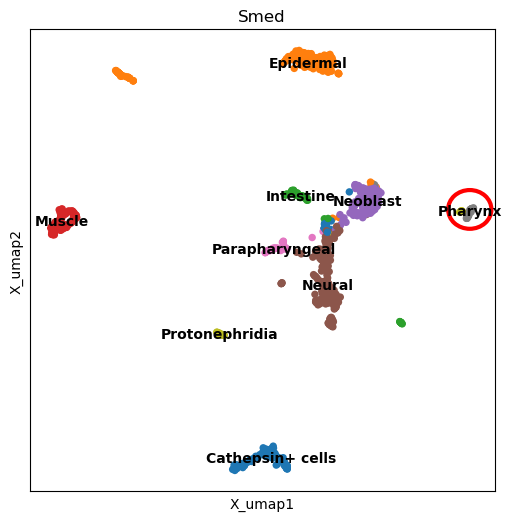

In [ ]:
highlighted_dimplot(planarian, "Smed", "tissue", "Pharynx", figsize=(6, 6))

Of course, if a cluster is too spread out, the plot will not work as well, but it will still be
useful to see the general location of the cluster.

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


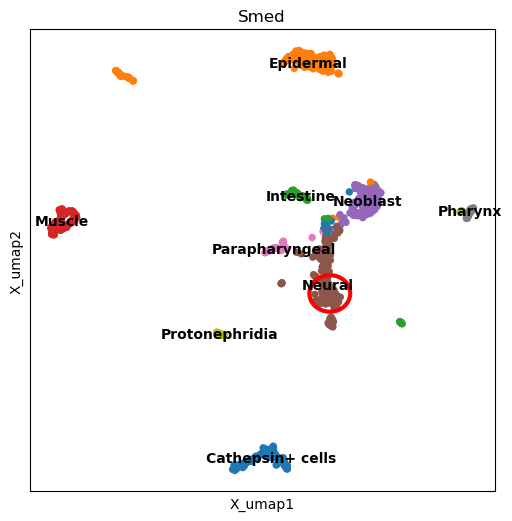

In [ ]:
highlighted_dimplot(planarian, "Smed", "tissue", "Neural", figsize=(6, 6))

Another case that might not work so well is if the shape of a cluster is not Gaussian. Still, it
should help us spot the cluster, especially if the color contrasts enough.

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


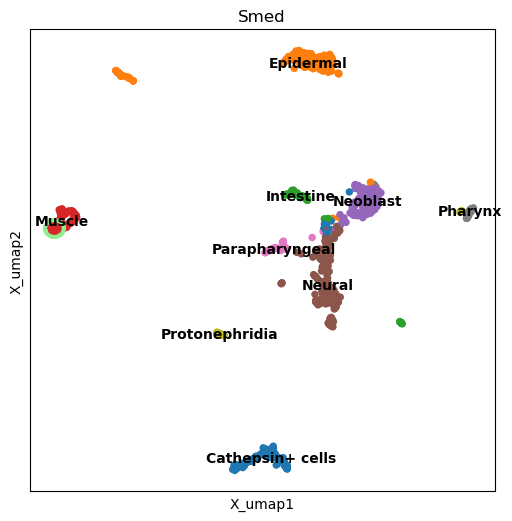

In [ ]:
highlighted_dimplot(
    planarian, "Smed", "tissue", "Muscle", figsize=(6, 6), highlight="lightgreen"
)


In [ ]:
hysc = pd.read_csv("../example_data/hysc_similarity_table.csv", index_col=0)

In [ ]:
file = open("../example_data/hypl.pkl", "rb")
sm = pickle.load(file)

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


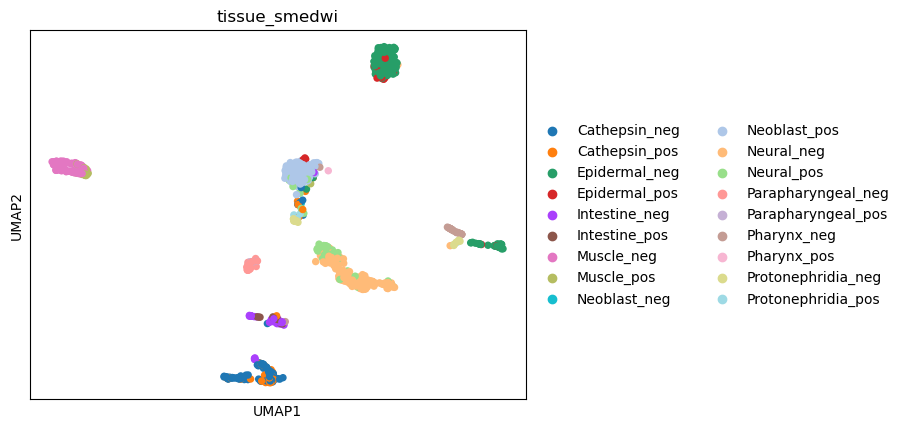

In [ ]:
target_map, target_lut, target_handles = util.map_fine_to_coarse(
    sm, "pl", "cluster", "tissue_smedwi"
)


In [ ]:
def plot_overview(
    sm,
    similarity,
    query_species,
    target_species,
    query_clustering,
    target_clustering,
    query_coarse=None,
    target_coarse=None,
    save=None,
):
    "Plot the similarity matrix as an annotated heatmap."
    query_map, query_lut, query_handles = util.map_fine_to_coarse(
        sm, query_species, query_clustering, query_coarse
    )
    target_map, target_lut, target_handles = util.map_fine_to_coarse(
        sm, target_species, target_clustering, target_coarse
    )

    query_map[query_coarse] = query_map[query_coarse].replace(to_replace=query_lut)
    target_map[target_coarse] = target_map[target_coarse].replace(to_replace=target_lut)

    sns.clustermap(
        similarity,
        cmap="magma_r",
        figsize=(25, 20),
        col_cluster=None,
        row_cluster=None,
        dendrogram_ratio=0.1,
        colors_ratio=0.02,
        cbar_pos=(0.04, 0.75, 0.02, 0.15),
        row_colors=target_map.set_index(target_clustering)[target_coarse],
        col_colors=query_map.set_index(query_clustering)[query_coarse],
        linecolor="black",
        linewidths=0.5,
    )

    query_legend = plt.legend(
        query_handles,
        query_lut,
        title=f"{query_species}\nmajor cell types",
        bbox_to_anchor=(0.07, 0.7),
        bbox_transform=plt.gcf().transFigure,
        loc="upper right",
    )
    plt.gca().add_artist(query_legend)

    plt.legend(
        target_handles,
        target_lut,
        title=f"{target_species}\nmajor cell types",
        bbox_to_anchor=(0.06, 0.5),
        bbox_transform=plt.gcf().transFigure,
        loc="upper right",
    )

    if save is not None:
        plt.savefig(save)


In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()
